# Question 3

## Importing libraries and loading dataset

In [9]:
import numpy as np
import pandas as pd
import os


#Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import umap.umap_ as umap


#NLP tools
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
#loading the dataset
df=pd.read_json(r"News_Category_Dataset_v3.json", lines=True)

## Accessing the dataset

In [11]:
#Checking out few samples of the dataset
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [12]:
#Checking the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


## Cleaning: Null and Duplicate

In [13]:
#Checking for missing values
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [14]:
#Checking for duplicates
dup=df.duplicated().sum()
print(f"The dataset contains {dup} duplicates which can be easliy dropped")

The dataset contains 13 duplicates which can be easliy dropped


In [15]:
df=df.drop_duplicates()

In [16]:
assert df.duplicated().sum()==0

## Extracting recent published part of the dataset (2019 to 2022)

In [17]:
#Extracting recent news articles
news_df= df[df['date'] >= pd.Timestamp(2019,1,1)]

In [18]:
#Checking the shape
shape=news_df.shape
print(f"The shape of the dataset is:", shape)

The shape of the dataset is: (7523, 6)


## A quick view of the news categories and headline

In [19]:
#Extracting the categories and the values counts
cat=news_df.category.value_counts(normalize=True, sort=False)*1000
df_counts=cat.rename_axis('Unique_cat').to_frame('counts')
df_counts=df_counts.reset_index()

In [20]:
#Plotting function visualize the categories of the news articles
def circular_bar(df, col_name, col_counts):
# initialize the figure
    plt.figure(figsize=(15,20))
    ax = plt.subplot(111, polar=True)
    plt.axis('off')


# Set the coordinates limits
    upperLimit = 100
    lowerLimit = 40

    maxi = df[col_counts].max()
    slope = (maxi - lowerLimit) / maxi
    heights = slope * df[col_counts] + lowerLimit



# Compute the width of each bar. In total we have 2*Pi = 360°
    width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
    indexes = list(range(1, len(df.index)+1))
    angles = [element * width for element in indexes]
    angles
# Draw bars
    bars = ax.bar(
        x=angles, 
        height=heights, 
        width=width, 
        bottom=lowerLimit,
        linewidth=1, 
        edgecolor="black",
        color="#61a4b2",
    )

# little space between the bar and the label
    labelPadding = 4

# Add labels
    for bar, angle, height, label in zip(bars,angles, heights, df[col_name]):

    # Labels are rotated. Rotation must be specified in degrees :(
        rotation = np.rad2deg(angle)

    # Flip some labels upside down
        alignment = ""
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

    # Finally add the labels
        ax.text(
            x=angle, 
            y=lowerLimit + bar.get_height() + labelPadding, 
            s=label, 
            ha=alignment, 
            va='center', 
            rotation=rotation, 
            rotation_mode="anchor") 
    plt.show()

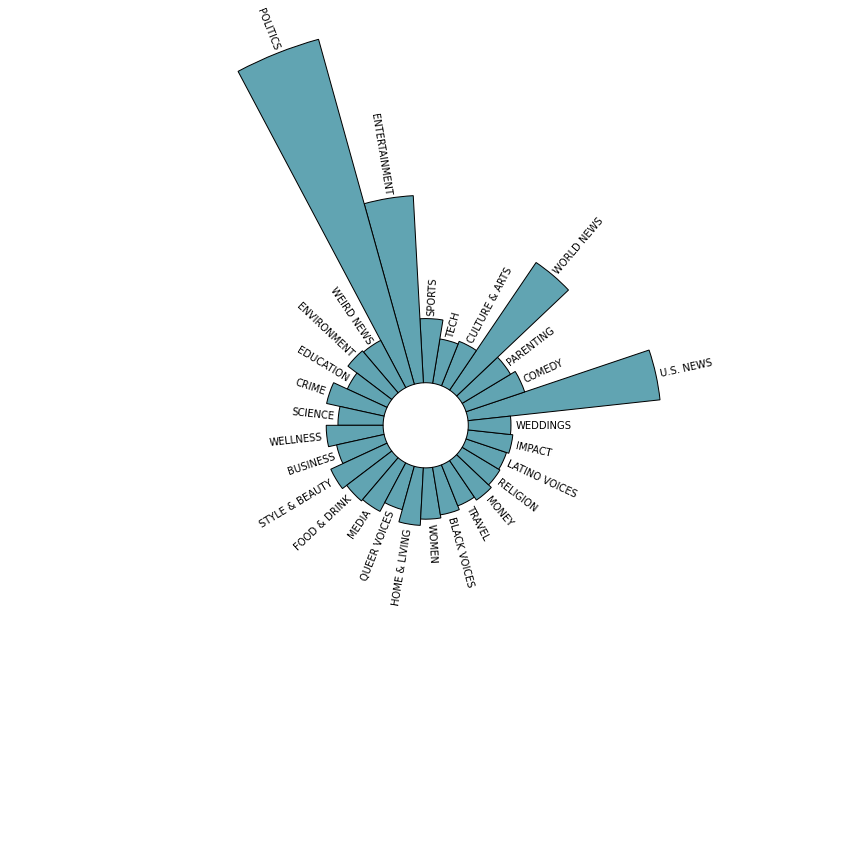

In [21]:
#Applying the function on the extracted category dataset
circular_bar(df_counts, 'Unique_cat', 'counts')

##  Text data Preprocessing

In [22]:
#Concatenating the headline and the short description column
news_df["news_text"] =news_df["headline"] + " " + news_df["short_description"] 

C:\Users\Admin\AppData\Local\Temp\ipykernel_20568\2918903318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df["news_text"] =news_df["headline"] + " " + news_df["short_description"]


In [23]:
#Drop unnused columns from the dataset
news_df=news_df.drop(columns=["link", "authors", "category", "date", "short_description"])

In [24]:
'''import nltk
nltk.download('all')'''

[nltk_data] Error loading all: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [25]:
en_stopwords =nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [26]:
#Defining th preprocessing function
def process(text):
    text = re.sub("[^A-Za-z1-9 ]", "", text)
    text = text.lower()
    tokens = word_tokenize(text)
    clean_list = []
    for token in tokens:
        if token not in en_stopwords:
            clean_list.append(lemmatizer.lemmatize(token))
    return " ".join(clean_list)

In [27]:
news_df.news_text = news_df.news_text.apply(process)